How can we make use of the recommended policy data points that we have generated? One way is to create a dataset with the recommended policies as the target variable.

Below is a small reproducible example to show how we can use our generated recommendations, create a dataset, fit a prediction model and use feature importance to understand what is driving the predictions.

Who can make use of this data? Travel insurance companies to better understand what kind of customers segments prefer their own policies.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import shap

np.random.seed(2025)

# Set Seaborn style
sns.set(style="whitegrid")

# Generate synthetic dataset

In [ ]:
n_rows = 500

# Define possible values for each column and (when desired) probabilities for imbalance.
age_bands = ["18-30", "31-45", "46-60", "60+"]
genders = ["Male", "Female"]
gender_probs = [0.3, 0.7]  # imbalanced: more Female than Male
solo_options = ["Yes", "No"]
solo_probs = [0.2, 0.8]    # imbalanced: most are not solo travellers
destination_continents = ["Europe", "Asia", "Africa", "North America", "South America", "Oceania"]
dest_probs = [0.5, 0.2, 0.1, 0.1, 0.05, 0.05]  # imbalanced: Europe dominates
coverage_options = ["Yes", "No"]
trip_cancellation_probs = [0.7, 0.3]       # majority require trip cancellation coverage
travel_delay_probs = [0.8, 0.2]            # majority require travel delay coverage
natural_disaster_probs = [0.8, 0.2]        # very high requirement for natural disaster coverage
policy =  ['A', 'B', 'C']
policy_probs = [0.7, 0.1, 0.2]

# Create the DataFrame with randomly sampled features.
df = pd.DataFrame({
    "Age_band": np.random.choice(age_bands, size=n_rows),
    "gender": np.random.choice(genders, size=n_rows, p=gender_probs),
    "solo_traveller": np.random.choice(solo_options, size=n_rows, p=solo_probs),
    "destination_continent": np.random.choice(destination_continents, size=n_rows, p=dest_probs),
    "req_trip_cancellation_coverage": np.random.choice(coverage_options, size=n_rows, p=trip_cancellation_probs),
    "req_travel_delay_coverage": np.random.choice(coverage_options, size=n_rows, p=travel_delay_probs),
    "req_natural_disaster_coverage": np.random.choice(coverage_options, size=n_rows, p=natural_disaster_probs),
    "policy": np.random.choice(policy, size=n_rows, p=policy_probs)
})

# Display the first few rows of the synthetic dataset.
df.head()


,Age_band,gender,solo_traveller,destination_continent,req_trip_cancellation_coverage,req_travel_delay_coverage,req_natural_disaster_coverage,policy
0,46-60,Male,No,Europe,No,Yes,No,B
1,46-60,Male,No,Europe,Yes,Yes,Yes,A
2,46-60,Female,No,Asia,Yes,Yes,No,A
3,46-60,Female,No,Asia,Yes,No,Yes,C
4,18-30,Female,Yes,Asia,No,Yes,Yes,C


In [ ]:
df['policy'].value_counts(sort=True)

,count
policy,
A,350
C,97
B,53


# Management of Company A



Company A issued policy A. Now management wants to understand what kind of customers prefer their policy.

We turn the dataset into a binary classification and run a predictive model over it. Then, if model performance is satisfactory, we can then interpret feature importance.

In [ ]:
# Binarize Policy: A = 1, B/C = 0
df['policy_binary'] = df['policy'].apply(lambda x: 1 if x == 'A' else 0)

# Convert categorical variables to numeric (one-hot encoding)
df_encoded = pd.get_dummies(df.drop(['policy', 'policy_binary'], axis=1))
X = df_encoded
y = df['policy_binary']  # Binary target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)


In [ ]:
df['policy'].value_counts()

,count
policy,
A,350
C,97
B,53


In [ ]:
df['policy_binary'].value_counts()

,count
policy_binary,
1,350
0,150


# Train a Random Forest

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=2025)  # Handle imbalance
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=500, random_state=2025)

Check model performance.

In [ ]:
print(f"Model accuracy: {rf.score(X_test, y_test):.2f}")



Model accuracy: 0.62


# Get Feature Importance

<ipython-input-9-90639023ae6e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(10), palette='viridis')


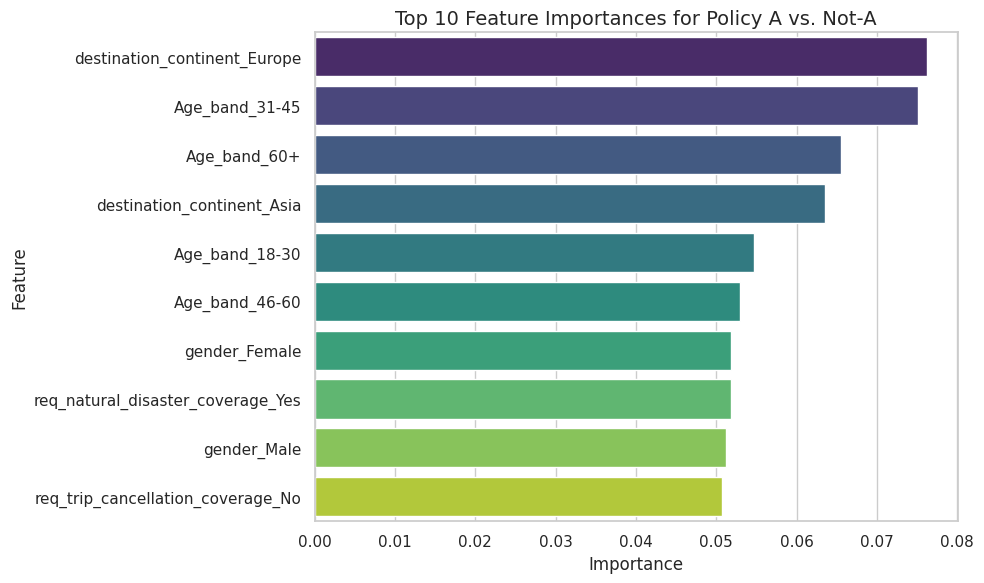

In [ ]:
# --- Feature Importances with Seaborn ---
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances for Policy A vs. Not-A', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()



from the above feature importance plot, we can see that the customer segment that prefers policy A tends to be travellers to Europe & Asia, comprising of middle-aged and senior citizens.

Company A can now run the same analysis on the competitors' products as well. They just have to change the target variable and make the model predict that competitor's policy, then we run the feature importance plot.